In [2]:
import os
import sys
import itertools
from tqdm import tqdm_notebook as tqdm

import numpy as np
import pandas as pd
from scipy.stats import spearmanr

from matplotlib import pyplot as plt
from matplotlib_venn import venn2, venn3
import seaborn as sns

import torch
from torch import nn, optim
from transformers import BertConfig, BertTokenizer, BertModel, BertForMaskedLM#, BertLayer, BertEmbeddings
from transformers.modeling_bert import BertLayer, BertEmbeddings

In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# re-load functions
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%config InlineBackend.figure_formats = {'png', 'retina'}

In [4]:
DEVICE = 'cpu'

## load tf weights

In [5]:
import tensorflow_hub as hub
import tensorflow as tf

In [6]:
BERT_PATH = '../mnt/datasets/kernel_tf_weight/bert_en_uncased_L-12_H-768_A-12/'

In [8]:
keras_model = hub.KerasLayer(BERT_PATH, trainable=True)

In [9]:
keras_weights = keras_model.weights
keras_weights

[<tf.Variable 'bert_model/word_embeddings/embeddings:0' shape=(30522, 768) dtype=float32, numpy=
 array([[-0.01018257, -0.06154883, -0.02649689, ..., -0.01985357,
         -0.03720997, -0.00975152],
        [-0.01170495, -0.06002603, -0.03233192, ..., -0.01681456,
         -0.04009988, -0.0106634 ],
        [-0.01975381, -0.06273633, -0.03262176, ..., -0.01650258,
         -0.04198876, -0.00323178],
        ...,
        [-0.02176224, -0.0556396 , -0.01346345, ..., -0.00432698,
         -0.0151355 , -0.02489496],
        [-0.04617237, -0.05647721, -0.00192082, ...,  0.01568751,
         -0.01387033, -0.00945213],
        [ 0.00145601, -0.08208051, -0.01597912, ..., -0.00811687,
         -0.04746607,  0.07527421]], dtype=float32)>,
 <tf.Variable 'bert_model/embedding_postprocessor/type_embeddings:0' shape=(2, 768) dtype=float32, numpy=
 array([[ 0.00043164,  0.01098826,  0.00370439, ..., -0.00661185,
         -0.00336983, -0.00864201],
        [ 0.00111319, -0.00299169, -0.00317028, ...,

In [10]:
for keras_weight in keras_weights:
    print(keras_weight.name)

bert_model/word_embeddings/embeddings:0
bert_model/embedding_postprocessor/type_embeddings:0
bert_model/embedding_postprocessor/position_embeddings:0
bert_model/embedding_postprocessor/layer_norm/gamma:0
bert_model/embedding_postprocessor/layer_norm/beta:0
bert_model/encoder/layer_0/self_attention/query/kernel:0
bert_model/encoder/layer_0/self_attention/query/bias:0
bert_model/encoder/layer_0/self_attention/key/kernel:0
bert_model/encoder/layer_0/self_attention/key/bias:0
bert_model/encoder/layer_0/self_attention/value/kernel:0
bert_model/encoder/layer_0/self_attention/value/bias:0
bert_model/encoder/layer_0/self_attention_output/kernel:0
bert_model/encoder/layer_0/self_attention_output/bias:0
bert_model/encoder/layer_0/self_attention_layer_norm/gamma:0
bert_model/encoder/layer_0/self_attention_layer_norm/beta:0
bert_model/encoder/layer_0/intermediate/kernel:0
bert_model/encoder/layer_0/intermediate/bias:0
bert_model/encoder/layer_0/output/kernel:0
bert_model/encoder/layer_0/output/bia

#### load torch model

In [84]:
model = BertModel.from_pretrained('bert-base-uncased')
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [39]:
weights = model.state_dict()
list(weights.keys())

['embeddings.word_embeddings.weight',
 'embeddings.position_embeddings.weight',
 'embeddings.token_type_embeddings.weight',
 'embeddings.LayerNorm.weight',
 'embeddings.LayerNorm.bias',
 'encoder.layer.0.attention.self.query.weight',
 'encoder.layer.0.attention.self.query.bias',
 'encoder.layer.0.attention.self.key.weight',
 'encoder.layer.0.attention.self.key.bias',
 'encoder.layer.0.attention.self.value.weight',
 'encoder.layer.0.attention.self.value.bias',
 'encoder.layer.0.attention.output.dense.weight',
 'encoder.layer.0.attention.output.dense.bias',
 'encoder.layer.0.attention.output.LayerNorm.weight',
 'encoder.layer.0.attention.output.LayerNorm.bias',
 'encoder.layer.0.intermediate.dense.weight',
 'encoder.layer.0.intermediate.dense.bias',
 'encoder.layer.0.output.dense.weight',
 'encoder.layer.0.output.dense.bias',
 'encoder.layer.0.output.LayerNorm.weight',
 'encoder.layer.0.output.LayerNorm.bias',
 'encoder.layer.1.attention.self.query.weight',
 'encoder.layer.1.attention.se

In [10]:
for keras_weight in keras_weights:
    print(keras_weight.name)

bert_model/word_embeddings/embeddings:0
bert_model/embedding_postprocessor/type_embeddings:0
bert_model/embedding_postprocessor/position_embeddings:0
bert_model/embedding_postprocessor/layer_norm/gamma:0
bert_model/embedding_postprocessor/layer_norm/beta:0
bert_model/encoder/layer_0/self_attention/query/kernel:0
bert_model/encoder/layer_0/self_attention/query/bias:0
bert_model/encoder/layer_0/self_attention/key/kernel:0
bert_model/encoder/layer_0/self_attention/key/bias:0
bert_model/encoder/layer_0/self_attention/value/kernel:0
bert_model/encoder/layer_0/self_attention/value/bias:0
bert_model/encoder/layer_0/self_attention_output/kernel:0
bert_model/encoder/layer_0/self_attention_output/bias:0
bert_model/encoder/layer_0/self_attention_layer_norm/gamma:0
bert_model/encoder/layer_0/self_attention_layer_norm/beta:0
bert_model/encoder/layer_0/intermediate/kernel:0
bert_model/encoder/layer_0/intermediate/bias:0
bert_model/encoder/layer_0/output/kernel:0
bert_model/encoder/layer_0/output/bia

#### name をうまく convert できれば weight 使える...！

In [21]:
pth_to_tf = {
    'embeddings.word_embeddings.weight': 'bert_model/word_embeddings/embeddings:0',
    'embeddings.position_embeddings.weight': 'bert_model/embedding_postprocessor/position_embeddings:0',
    'embeddings.token_type_embeddings.weight': 'bert_model/embedding_postprocessor/type_embeddings:0',
    'embeddings.LayerNorm.weight': 'bert_model/embedding_postprocessor/layer_norm/gamma:0',
    'embeddings.LayerNorm.bias': 'bert_model/embedding_postprocessor/layer_norm/beta:0',

    'encoder.layer.0.attention.self.query.weight': 'bert_model/encoder/layer_0/self_attention/query/kernel:0',
    'encoder.layer.0.attention.self.query.bias': 'bert_model/encoder/layer_0/self_attention/query/bias:0',
    'encoder.layer.0.attention.self.key.weight': 'bert_model/encoder/layer_0/self_attention/key/kernel:0',
    'encoder.layer.0.attention.self.key.bias': 'bert_model/encoder/layer_0/self_attention/key/bias:0',
    'encoder.layer.0.attention.self.value.weight': 'bert_model/encoder/layer_0/self_attention/value/kernel:0',
    'encoder.layer.0.attention.self.value.bias': 'bert_model/encoder/layer_0/self_attention/value/bias:0',
    'encoder.layer.0.attention.output.dense.weight': 'bert_model/encoder/layer_0/self_attention_output/kernel:0',
    'encoder.layer.0.attention.output.dense.bias': 'bert_model/encoder/layer_0/self_attention_output/bias:0',
    'encoder.layer.0.attention.output.LayerNorm.weight': 'bert_model/encoder/layer_0/self_attention_layer_norm/gamma:0',
    'encoder.layer.0.attention.output.LayerNorm.bias': 'bert_model/encoder/layer_0/self_attention_layer_norm/beta:0',
    'encoder.layer.0.intermediate.dense.weight': 'bert_model/encoder/layer_0/intermediate/kernel:0',
    'encoder.layer.0.intermediate.dense.bias': 'bert_model/encoder/layer_0/intermediate/bias:0',
    'encoder.layer.0.output.dense.weight': 'bert_model/encoder/layer_0/output/kernel:0',
    'encoder.layer.0.output.dense.bias': 'bert_model/encoder/layer_0/output/bias:0',
    'encoder.layer.0.output.LayerNorm.weight': 'bert_model/encoder/layer_0/output_layer_norm/gamma:0',
    'encoder.layer.0.output.LayerNorm.bias': 'bert_model/encoder/layer_0/output_layer_norm/beta:0',

    'encoder.layer.1.attention.self.query.weight': 'bert_model/encoder/layer_1/self_attention/query/kernel:0',
    'encoder.layer.1.attention.self.query.bias': 'bert_model/encoder/layer_1/self_attention/query/bias:0',
    'encoder.layer.1.attention.self.key.weight': 'bert_model/encoder/layer_1/self_attention/key/kernel:0',
    'encoder.layer.1.attention.self.key.bias': 'bert_model/encoder/layer_1/self_attention/key/bias:0',
    'encoder.layer.1.attention.self.value.weight': 'bert_model/encoder/layer_1/self_attention/value/kernel:0',
    'encoder.layer.1.attention.self.value.bias': 'bert_model/encoder/layer_1/self_attention/value/bias:0',
    'encoder.layer.1.attention.output.dense.weight': 'bert_model/encoder/layer_1/self_attention_output/kernel:0',
    'encoder.layer.1.attention.output.dense.bias': 'bert_model/encoder/layer_1/self_attention_output/bias:0',
    'encoder.layer.1.attention.output.LayerNorm.weight': 'bert_model/encoder/layer_1/self_attention_layer_norm/gamma:0',
    'encoder.layer.1.attention.output.LayerNorm.bias': 'bert_model/encoder/layer_1/self_attention_layer_norm/beta:0',
    'encoder.layer.1.intermediate.dense.weight': 'bert_model/encoder/layer_1/intermediate/kernel:0',
    'encoder.layer.1.intermediate.dense.bias': 'bert_model/encoder/layer_1/intermediate/bias:0',
    'encoder.layer.1.output.dense.weight': 'bert_model/encoder/layer_1/output/kernel:0',
    'encoder.layer.1.output.dense.bias': 'bert_model/encoder/layer_1/output/bias:0',
    'encoder.layer.1.output.LayerNorm.weight': 'bert_model/encoder/layer_1/output_layer_norm/gamma:0',
    'encoder.layer.1.output.LayerNorm.bias': 'bert_model/encoder/layer_1/output_layer_norm/beta:0',
 
    'encoder.layer.2.attention.self.query.weight': 'bert_model/encoder/layer_2/self_attention/query/kernel:0',
    'encoder.layer.2.attention.self.query.bias': 'bert_model/encoder/layer_2/self_attention/query/bias:0',
    'encoder.layer.2.attention.self.key.weight': 'bert_model/encoder/layer_2/self_attention/key/kernel:0',
    'encoder.layer.2.attention.self.key.bias': 'bert_model/encoder/layer_2/self_attention/key/bias:0',
    'encoder.layer.2.attention.self.value.weight': 'bert_model/encoder/layer_2/self_attention/value/kernel:0',
    'encoder.layer.2.attention.self.value.bias': 'bert_model/encoder/layer_2/self_attention/value/bias:0',
    'encoder.layer.2.attention.output.dense.weight': 'bert_model/encoder/layer_2/self_attention_output/kernel:0',
    'encoder.layer.2.attention.output.dense.bias': 'bert_model/encoder/layer_2/self_attention_output/bias:0',
    'encoder.layer.2.attention.output.LayerNorm.weight': 'bert_model/encoder/layer_2/self_attention_layer_norm/gamma:0',
    'encoder.layer.2.attention.output.LayerNorm.bias': 'bert_model/encoder/layer_2/self_attention_layer_norm/beta:0',
    'encoder.layer.2.intermediate.dense.weight': 'bert_model/encoder/layer_2/intermediate/kernel:0',
    'encoder.layer.2.intermediate.dense.bias': 'bert_model/encoder/layer_2/intermediate/bias:0',
    'encoder.layer.2.output.dense.weight': 'bert_model/encoder/layer_2/output/kernel:0',
    'encoder.layer.2.output.dense.bias': 'bert_model/encoder/layer_2/output/bias:0',
    'encoder.layer.2.output.LayerNorm.weight': 'bert_model/encoder/layer_2/output_layer_norm/gamma:0',
    'encoder.layer.2.output.LayerNorm.bias': 'bert_model/encoder/layer_2/output_layer_norm/beta:0',
  
    'encoder.layer.3.attention.self.query.weight': 'bert_model/encoder/layer_3/self_attention/query/kernel:0',
    'encoder.layer.3.attention.self.query.bias': 'bert_model/encoder/layer_3/self_attention/query/bias:0',
    'encoder.layer.3.attention.self.key.weight': 'bert_model/encoder/layer_3/self_attention/key/kernel:0',
    'encoder.layer.3.attention.self.key.bias': 'bert_model/encoder/layer_3/self_attention/key/bias:0',
    'encoder.layer.3.attention.self.value.weight': 'bert_model/encoder/layer_3/self_attention/value/kernel:0',
    'encoder.layer.3.attention.self.value.bias': 'bert_model/encoder/layer_3/self_attention/value/bias:0',
    'encoder.layer.3.attention.output.dense.weight': 'bert_model/encoder/layer_3/self_attention_output/kernel:0',
    'encoder.layer.3.attention.output.dense.bias': 'bert_model/encoder/layer_3/self_attention_output/bias:0',
    'encoder.layer.3.attention.output.LayerNorm.weight': 'bert_model/encoder/layer_3/self_attention_layer_norm/gamma:0',
    'encoder.layer.3.attention.output.LayerNorm.bias': 'bert_model/encoder/layer_3/self_attention_layer_norm/beta:0',
    'encoder.layer.3.intermediate.dense.weight': 'bert_model/encoder/layer_3/intermediate/kernel:0',
    'encoder.layer.3.intermediate.dense.bias': 'bert_model/encoder/layer_3/intermediate/bias:0',
    'encoder.layer.3.output.dense.weight': 'bert_model/encoder/layer_3/output/kernel:0',
    'encoder.layer.3.output.dense.bias': 'bert_model/encoder/layer_3/output/bias:0',
    'encoder.layer.3.output.LayerNorm.weight': 'bert_model/encoder/layer_3/output_layer_norm/gamma:0',
    'encoder.layer.3.output.LayerNorm.bias': 'bert_model/encoder/layer_3/output_layer_norm/beta:0',
  
    'encoder.layer.4.attention.self.query.weight': 'bert_model/encoder/layer_4/self_attention/query/kernel:0',
    'encoder.layer.4.attention.self.query.bias': 'bert_model/encoder/layer_4/self_attention/query/bias:0',
    'encoder.layer.4.attention.self.key.weight': 'bert_model/encoder/layer_4/self_attention/key/kernel:0',
    'encoder.layer.4.attention.self.key.bias': 'bert_model/encoder/layer_4/self_attention/key/bias:0',
    'encoder.layer.4.attention.self.value.weight': 'bert_model/encoder/layer_4/self_attention/value/kernel:0',
    'encoder.layer.4.attention.self.value.bias': 'bert_model/encoder/layer_4/self_attention/value/bias:0',
    'encoder.layer.4.attention.output.dense.weight': 'bert_model/encoder/layer_4/self_attention_output/kernel:0',
    'encoder.layer.4.attention.output.dense.bias': 'bert_model/encoder/layer_4/self_attention_output/bias:0',
    'encoder.layer.4.attention.output.LayerNorm.weight': 'bert_model/encoder/layer_4/self_attention_layer_norm/gamma:0',
    'encoder.layer.4.attention.output.LayerNorm.bias': 'bert_model/encoder/layer_4/self_attention_layer_norm/beta:0',
    'encoder.layer.4.intermediate.dense.weight': 'bert_model/encoder/layer_4/intermediate/kernel:0',
    'encoder.layer.4.intermediate.dense.bias': 'bert_model/encoder/layer_4/intermediate/bias:0',
    'encoder.layer.4.output.dense.weight': 'bert_model/encoder/layer_4/output/kernel:0',
    'encoder.layer.4.output.dense.bias': 'bert_model/encoder/layer_4/output/bias:0',
    'encoder.layer.4.output.LayerNorm.weight': 'bert_model/encoder/layer_4/output_layer_norm/gamma:0',
    'encoder.layer.4.output.LayerNorm.bias': 'bert_model/encoder/layer_4/output_layer_norm/beta:0',
  
    'encoder.layer.5.attention.self.query.weight': 'bert_model/encoder/layer_5/self_attention/query/kernel:0',
    'encoder.layer.5.attention.self.query.bias': 'bert_model/encoder/layer_5/self_attention/query/bias:0',
    'encoder.layer.5.attention.self.key.weight': 'bert_model/encoder/layer_5/self_attention/key/kernel:0',
    'encoder.layer.5.attention.self.key.bias': 'bert_model/encoder/layer_5/self_attention/key/bias:0',
    'encoder.layer.5.attention.self.value.weight': 'bert_model/encoder/layer_5/self_attention/value/kernel:0',
    'encoder.layer.5.attention.self.value.bias': 'bert_model/encoder/layer_5/self_attention/value/bias:0',
    'encoder.layer.5.attention.output.dense.weight': 'bert_model/encoder/layer_5/self_attention_output/kernel:0',
    'encoder.layer.5.attention.output.dense.bias': 'bert_model/encoder/layer_5/self_attention_output/bias:0',
    'encoder.layer.5.attention.output.LayerNorm.weight': 'bert_model/encoder/layer_5/self_attention_layer_norm/gamma:0',
    'encoder.layer.5.attention.output.LayerNorm.bias': 'bert_model/encoder/layer_5/self_attention_layer_norm/beta:0',
    'encoder.layer.5.intermediate.dense.weight': 'bert_model/encoder/layer_5/intermediate/kernel:0',
    'encoder.layer.5.intermediate.dense.bias': 'bert_model/encoder/layer_5/intermediate/bias:0',
    'encoder.layer.5.output.dense.weight': 'bert_model/encoder/layer_5/output/kernel:0',
    'encoder.layer.5.output.dense.bias': 'bert_model/encoder/layer_5/output/bias:0',
    'encoder.layer.5.output.LayerNorm.weight': 'bert_model/encoder/layer_5/output_layer_norm/gamma:0',
    'encoder.layer.5.output.LayerNorm.bias': 'bert_model/encoder/layer_5/output_layer_norm/beta:0',
  
    'encoder.layer.6.attention.self.query.weight': 'bert_model/encoder/layer_6/self_attention/query/kernel:0',
    'encoder.layer.6.attention.self.query.bias': 'bert_model/encoder/layer_6/self_attention/query/bias:0',
    'encoder.layer.6.attention.self.key.weight': 'bert_model/encoder/layer_6/self_attention/key/kernel:0',
    'encoder.layer.6.attention.self.key.bias': 'bert_model/encoder/layer_6/self_attention/key/bias:0',
    'encoder.layer.6.attention.self.value.weight': 'bert_model/encoder/layer_6/self_attention/value/kernel:0',
    'encoder.layer.6.attention.self.value.bias': 'bert_model/encoder/layer_6/self_attention/value/bias:0',
    'encoder.layer.6.attention.output.dense.weight': 'bert_model/encoder/layer_6/self_attention_output/kernel:0',
    'encoder.layer.6.attention.output.dense.bias': 'bert_model/encoder/layer_6/self_attention_output/bias:0',
    'encoder.layer.6.attention.output.LayerNorm.weight': 'bert_model/encoder/layer_6/self_attention_layer_norm/gamma:0',
    'encoder.layer.6.attention.output.LayerNorm.bias': 'bert_model/encoder/layer_6/self_attention_layer_norm/beta:0',
    'encoder.layer.6.intermediate.dense.weight': 'bert_model/encoder/layer_6/intermediate/kernel:0',
    'encoder.layer.6.intermediate.dense.bias': 'bert_model/encoder/layer_6/intermediate/bias:0',
    'encoder.layer.6.output.dense.weight': 'bert_model/encoder/layer_6/output/kernel:0',
    'encoder.layer.6.output.dense.bias': 'bert_model/encoder/layer_6/output/bias:0',
    'encoder.layer.6.output.LayerNorm.weight': 'bert_model/encoder/layer_6/output_layer_norm/gamma:0',
    'encoder.layer.6.output.LayerNorm.bias': 'bert_model/encoder/layer_6/output_layer_norm/beta:0',
  
    'encoder.layer.7.attention.self.query.weight': 'bert_model/encoder/layer_7/self_attention/query/kernel:0',
    'encoder.layer.7.attention.self.query.bias': 'bert_model/encoder/layer_7/self_attention/query/bias:0',
    'encoder.layer.7.attention.self.key.weight': 'bert_model/encoder/layer_7/self_attention/key/kernel:0',
    'encoder.layer.7.attention.self.key.bias': 'bert_model/encoder/layer_7/self_attention/key/bias:0',
    'encoder.layer.7.attention.self.value.weight': 'bert_model/encoder/layer_7/self_attention/value/kernel:0',
    'encoder.layer.7.attention.self.value.bias': 'bert_model/encoder/layer_7/self_attention/value/bias:0',
    'encoder.layer.7.attention.output.dense.weight': 'bert_model/encoder/layer_7/self_attention_output/kernel:0',
    'encoder.layer.7.attention.output.dense.bias': 'bert_model/encoder/layer_7/self_attention_output/bias:0',
    'encoder.layer.7.attention.output.LayerNorm.weight': 'bert_model/encoder/layer_7/self_attention_layer_norm/gamma:0',
    'encoder.layer.7.attention.output.LayerNorm.bias': 'bert_model/encoder/layer_7/self_attention_layer_norm/beta:0',
    'encoder.layer.7.intermediate.dense.weight': 'bert_model/encoder/layer_7/intermediate/kernel:0',
    'encoder.layer.7.intermediate.dense.bias': 'bert_model/encoder/layer_7/intermediate/bias:0',
    'encoder.layer.7.output.dense.weight': 'bert_model/encoder/layer_7/output/kernel:0',
    'encoder.layer.7.output.dense.bias': 'bert_model/encoder/layer_7/output/bias:0',
    'encoder.layer.7.output.LayerNorm.weight': 'bert_model/encoder/layer_7/output_layer_norm/gamma:0',
    'encoder.layer.7.output.LayerNorm.bias': 'bert_model/encoder/layer_7/output_layer_norm/beta:0',
  
    'encoder.layer.8.attention.self.query.weight': 'bert_model/encoder/layer_8/self_attention/query/kernel:0',
    'encoder.layer.8.attention.self.query.bias': 'bert_model/encoder/layer_8/self_attention/query/bias:0',
    'encoder.layer.8.attention.self.key.weight': 'bert_model/encoder/layer_8/self_attention/key/kernel:0',
    'encoder.layer.8.attention.self.key.bias': 'bert_model/encoder/layer_8/self_attention/key/bias:0',
    'encoder.layer.8.attention.self.value.weight': 'bert_model/encoder/layer_8/self_attention/value/kernel:0',
    'encoder.layer.8.attention.self.value.bias': 'bert_model/encoder/layer_8/self_attention/value/bias:0',
    'encoder.layer.8.attention.output.dense.weight': 'bert_model/encoder/layer_8/self_attention_output/kernel:0',
    'encoder.layer.8.attention.output.dense.bias': 'bert_model/encoder/layer_8/self_attention_output/bias:0',
    'encoder.layer.8.attention.output.LayerNorm.weight': 'bert_model/encoder/layer_8/self_attention_layer_norm/gamma:0',
    'encoder.layer.8.attention.output.LayerNorm.bias': 'bert_model/encoder/layer_8/self_attention_layer_norm/beta:0',
    'encoder.layer.8.intermediate.dense.weight': 'bert_model/encoder/layer_8/intermediate/kernel:0',
    'encoder.layer.8.intermediate.dense.bias': 'bert_model/encoder/layer_8/intermediate/bias:0',
    'encoder.layer.8.output.dense.weight': 'bert_model/encoder/layer_8/output/kernel:0',
    'encoder.layer.8.output.dense.bias': 'bert_model/encoder/layer_8/output/bias:0',
    'encoder.layer.8.output.LayerNorm.weight': 'bert_model/encoder/layer_8/output_layer_norm/gamma:0',
    'encoder.layer.8.output.LayerNorm.bias': 'bert_model/encoder/layer_8/output_layer_norm/beta:0',
  
    'encoder.layer.9.attention.self.query.weight': 'bert_model/encoder/layer_9/self_attention/query/kernel:0',
    'encoder.layer.9.attention.self.query.bias': 'bert_model/encoder/layer_9/self_attention/query/bias:0',
    'encoder.layer.9.attention.self.key.weight': 'bert_model/encoder/layer_9/self_attention/key/kernel:0',
    'encoder.layer.9.attention.self.key.bias': 'bert_model/encoder/layer_9/self_attention/key/bias:0',
    'encoder.layer.9.attention.self.value.weight': 'bert_model/encoder/layer_9/self_attention/value/kernel:0',
    'encoder.layer.9.attention.self.value.bias': 'bert_model/encoder/layer_9/self_attention/value/bias:0',
    'encoder.layer.9.attention.output.dense.weight': 'bert_model/encoder/layer_9/self_attention_output/kernel:0',
    'encoder.layer.9.attention.output.dense.bias': 'bert_model/encoder/layer_9/self_attention_output/bias:0',
    'encoder.layer.9.attention.output.LayerNorm.weight': 'bert_model/encoder/layer_9/self_attention_layer_norm/gamma:0',
    'encoder.layer.9.attention.output.LayerNorm.bias': 'bert_model/encoder/layer_9/self_attention_layer_norm/beta:0',
    'encoder.layer.9.intermediate.dense.weight': 'bert_model/encoder/layer_9/intermediate/kernel:0',
    'encoder.layer.9.intermediate.dense.bias': 'bert_model/encoder/layer_9/intermediate/bias:0',
    'encoder.layer.9.output.dense.weight': 'bert_model/encoder/layer_9/output/kernel:0',
    'encoder.layer.9.output.dense.bias': 'bert_model/encoder/layer_9/output/bias:0',
    'encoder.layer.9.output.LayerNorm.weight': 'bert_model/encoder/layer_9/output_layer_norm/gamma:0',
    'encoder.layer.9.output.LayerNorm.bias': 'bert_model/encoder/layer_9/output_layer_norm/beta:0',
  
    'encoder.layer.10.attention.self.query.weight': 'bert_model/encoder/layer_10/self_attention/query/kernel:0',
    'encoder.layer.10.attention.self.query.bias': 'bert_model/encoder/layer_10/self_attention/query/bias:0',
    'encoder.layer.10.attention.self.key.weight': 'bert_model/encoder/layer_10/self_attention/key/kernel:0',
    'encoder.layer.10.attention.self.key.bias': 'bert_model/encoder/layer_10/self_attention/key/bias:0',
    'encoder.layer.10.attention.self.value.weight': 'bert_model/encoder/layer_10/self_attention/value/kernel:0',
    'encoder.layer.10.attention.self.value.bias': 'bert_model/encoder/layer_10/self_attention/value/bias:0',
    'encoder.layer.10.attention.output.dense.weight': 'bert_model/encoder/layer_10/self_attention_output/kernel:0',
    'encoder.layer.10.attention.output.dense.bias': 'bert_model/encoder/layer_10/self_attention_output/bias:0',
    'encoder.layer.10.attention.output.LayerNorm.weight': 'bert_model/encoder/layer_10/self_attention_layer_norm/gamma:0',
    'encoder.layer.10.attention.output.LayerNorm.bias': 'bert_model/encoder/layer_10/self_attention_layer_norm/beta:0',
    'encoder.layer.10.intermediate.dense.weight': 'bert_model/encoder/layer_10/intermediate/kernel:0',
    'encoder.layer.10.intermediate.dense.bias': 'bert_model/encoder/layer_10/intermediate/bias:0',
    'encoder.layer.10.output.dense.weight': 'bert_model/encoder/layer_10/output/kernel:0',
    'encoder.layer.10.output.dense.bias': 'bert_model/encoder/layer_10/output/bias:0',
    'encoder.layer.10.output.LayerNorm.weight': 'bert_model/encoder/layer_10/output_layer_norm/gamma:0',
    'encoder.layer.10.output.LayerNorm.bias': 'bert_model/encoder/layer_10/output_layer_norm/beta:0',
  
    'encoder.layer.11.attention.self.query.weight': 'bert_model/encoder/layer_11/self_attention/query/kernel:0',
    'encoder.layer.11.attention.self.query.bias': 'bert_model/encoder/layer_11/self_attention/query/bias:0',
    'encoder.layer.11.attention.self.key.weight': 'bert_model/encoder/layer_11/self_attention/key/kernel:0',
    'encoder.layer.11.attention.self.key.bias': 'bert_model/encoder/layer_11/self_attention/key/bias:0',
    'encoder.layer.11.attention.self.value.weight': 'bert_model/encoder/layer_11/self_attention/value/kernel:0',
    'encoder.layer.11.attention.self.value.bias': 'bert_model/encoder/layer_11/self_attention/value/bias:0',
    'encoder.layer.11.attention.output.dense.weight': 'bert_model/encoder/layer_11/self_attention_output/kernel:0',
    'encoder.layer.11.attention.output.dense.bias': 'bert_model/encoder/layer_11/self_attention_output/bias:0',
    'encoder.layer.11.attention.output.LayerNorm.weight': 'bert_model/encoder/layer_11/self_attention_layer_norm/gamma:0',
    'encoder.layer.11.attention.output.LayerNorm.bias': 'bert_model/encoder/layer_11/self_attention_layer_norm/beta:0',
    'encoder.layer.11.intermediate.dense.weight': 'bert_model/encoder/layer_11/intermediate/kernel:0',
    'encoder.layer.11.intermediate.dense.bias': 'bert_model/encoder/layer_11/intermediate/bias:0',
    'encoder.layer.11.output.dense.weight': 'bert_model/encoder/layer_11/output/kernel:0',
    'encoder.layer.11.output.dense.bias': 'bert_model/encoder/layer_11/output/bias:0',
    'encoder.layer.11.output.LayerNorm.weight': 'bert_model/encoder/layer_11/output_layer_norm/gamma:0',
    'encoder.layer.11.output.LayerNorm.bias': 'bert_model/encoder/layer_11/output_layer_norm/beta:0',
  
    'pooler.dense.weight': 'bert_model/pooler_transform/kernel:0',
    'pooler.dense.bias': 'bert_model/pooler_transform/bias:0',
}

tf_to_pth = {v: k for k, v in pth_to_tf.items()}

In [76]:
for i, keras_weight in enumerate(keras_weights):
    tf_key = keras_weight.name
    pth_key = tf_to_pth[tf_key]
    print(i, pth_key)
    try:
        res = (weights[pth_key] == torch.tensor(keras_weight.numpy(), dtype=torch.float32)).numpy().all()
        if not res:
            res = (weights[pth_key].numpy().T == keras_weight.numpy()).all()
        print(res)
    except:
        print((weights[pth_key].numpy().T == keras_weight.numpy()).all())
    # weights[pth_key] = keras_weight.numpy()

0 embeddings.word_embeddings.weight
True
1 embeddings.token_type_embeddings.weight
True
2 embeddings.position_embeddings.weight
True
3 embeddings.LayerNorm.weight
True
4 embeddings.LayerNorm.bias
True
5 encoder.layer.0.attention.self.query.weight
True
6 encoder.layer.0.attention.self.query.bias
True
7 encoder.layer.0.attention.self.key.weight
True
8 encoder.layer.0.attention.self.key.bias
True
9 encoder.layer.0.attention.self.value.weight
True
10 encoder.layer.0.attention.self.value.bias
True
11 encoder.layer.0.attention.output.dense.weight
True
12 encoder.layer.0.attention.output.dense.bias
True
13 encoder.layer.0.attention.output.LayerNorm.weight
True
14 encoder.layer.0.attention.output.LayerNorm.bias
True
15 encoder.layer.0.intermediate.dense.weight
True
16 encoder.layer.0.intermediate.dense.bias
True
17 encoder.layer.0.output.dense.weight
True
18 encoder.layer.0.output.dense.bias
True
19 encoder.layer.0.output.LayerNorm.weight
True
20 encoder.layer.0.output.LayerNorm.bias
True
21 e

KeyError: 'Variable:0'

In [83]:
weights['embeddings.token_type_embeddings.weight'].dtype

torch.float32

In [73]:
res

True

In [28]:
keras_weight.numpy()

array([[-0.01018257, -0.06154883, -0.02649689, ..., -0.01985357,
        -0.03720997, -0.00975152],
       [-0.01170495, -0.06002603, -0.03233192, ..., -0.01681456,
        -0.04009988, -0.0106634 ],
       [-0.01975381, -0.06273633, -0.03262176, ..., -0.01650258,
        -0.04198876, -0.00323178],
       ...,
       [-0.02176224, -0.0556396 , -0.01346345, ..., -0.00432698,
        -0.0151355 , -0.02489496],
       [-0.04617237, -0.05647721, -0.00192082, ...,  0.01568751,
        -0.01387033, -0.00945213],
       [ 0.00145601, -0.08208051, -0.01597912, ..., -0.00811687,
        -0.04746607,  0.07527421]], dtype=float32)

In [40]:
weights[pth_key] = torch.tensor(keras_weight.numpy(), dtype=torch.float32)

In [77]:
weights[pth_key]

tensor([-3.5976e-02, -3.8954e-03,  5.1814e-02,  2.2247e-02, -4.9372e-03,
        -1.1203e-03,  2.6339e-02,  9.0639e-03,  3.8723e-02, -9.6557e-02,
         2.3311e-02, -2.0086e-02,  6.5490e-02, -5.1680e-02,  6.6156e-02,
        -1.4721e-02, -4.5325e-03, -8.4059e-04,  1.3027e-02, -2.9770e-02,
         4.3693e-02, -1.4292e-02,  4.5489e-02,  4.5346e-03,  7.6859e-03,
        -4.0926e-02, -1.1412e-02,  6.6037e-02,  6.7376e-02,  4.2859e-02,
        -2.6975e-02,  3.5281e-05, -8.1483e-02, -3.7569e-03,  4.0570e-02,
        -5.7694e-02, -8.3285e-03, -2.6218e-02, -4.7924e-03, -8.2249e-03,
        -6.4672e-02,  1.9579e-03,  7.2015e-02, -2.2552e-02,  3.4110e-03,
        -1.4251e-02, -8.3488e-03,  3.8957e-03, -5.5111e-02, -4.8916e-02,
        -4.0505e-02, -3.5423e-02,  6.1806e-03,  9.7887e-04,  2.5234e-03,
         3.8691e-03, -7.2486e-03, -2.1082e-03,  1.9743e-03, -1.5894e-02,
        -1.4470e-02,  3.2000e-03,  2.3056e-02, -4.6876e-02, -3.6722e-02,
        -7.3898e-02, -4.4587e-03,  5.0023e-03,  6.9

In [42]:
weights[pth_key] == torch.tensor(keras_weight.numpy(), dtype=torch.float32)

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [ ]:
'encoder.layer.0.intermediate.dense.weight': 'bert_model/encoder/layer_0/intermediate/kernel:0',

In [45]:
weights['encoder.layer.0.intermediate.dense.weight'].shape

torch.Size([3072, 768])

In [58]:
(keras_weights[i].numpy().T == weights['encoder.layer.0.intermediate.dense.weight'].numpy()).all()

True

In [52]:
weights['encoder.layer.0.intermediate.dense.weight']

tensor([[-0.0101, -0.0017,  0.0130,  ..., -0.0537,  0.0137, -0.0192],
        [-0.0604,  0.0104,  0.0648,  ..., -0.0486, -0.0277,  0.0070],
        [-0.0147,  0.0428,  0.0398,  ..., -0.0082,  0.0114, -0.0275],
        ...,
        [-0.0500, -0.0660,  0.0270,  ..., -0.0131,  0.0041,  0.0068],
        [ 0.0448, -0.0237,  0.0167,  ...,  0.0035,  0.0069,  0.0205],
        [-0.0094,  0.0363,  0.0258,  ..., -0.0086,  0.0064,  0.0604]])

In [61]:
# 5 encoder.layer.0.attention.self.query.weigh
weights['encoder.layer.0.attention.self.query.weight']

tensor([[-0.0164,  0.0261, -0.0263,  ...,  0.0154,  0.0768,  0.0548],
        [-0.0326,  0.0346, -0.0423,  ..., -0.0527,  0.1393,  0.0078],
        [ 0.0105,  0.0334,  0.0109,  ..., -0.0279,  0.0258, -0.0468],
        ...,
        [-0.0085,  0.0514,  0.0555,  ...,  0.0282,  0.0543, -0.0541],
        [-0.0198,  0.0944,  0.0617,  ..., -0.1042,  0.0601,  0.0470],
        [ 0.0015, -0.0952,  0.0099,  ..., -0.0191, -0.0508, -0.0085]])

In [62]:
keras_weights[5]

<tf.Variable 'bert_model/encoder/layer_0/self_attention/query/kernel:0' shape=(768, 768) dtype=float32, numpy=
array([[-0.01640572, -0.03257025,  0.01046295, ..., -0.00853848,
        -0.01982716,  0.00145311],
       [ 0.02607568,  0.03457963,  0.03342159, ...,  0.05144976,
         0.09437975, -0.09524117],
       [-0.02627701, -0.04234776,  0.01088208, ...,  0.05553847,
         0.06171984,  0.00991133],
       ...,
       [ 0.01537882, -0.05267428, -0.02788295, ...,  0.02824737,
        -0.10417847, -0.01913908],
       [ 0.07683044,  0.13925414,  0.02576543, ...,  0.05432997,
         0.06008924, -0.05083399],
       [ 0.05479865,  0.00776407, -0.04679608, ..., -0.05407076,
         0.04703793, -0.00845745]], dtype=float32)>

In [23]:
ls ../mnt/checkpoints/e027/

0/  1/  2/


In [3]:
cpt = torch.load('../mnt/checkpoints/e012/0/fold_0_epoch_3_0.37636_0.37515_checkpoint.pth')

In [97]:
cpt = torch.load('../mnt/checkpoints/e027/0/fold_0_epoch_3_0.04212_0.37204_checkpoint.pth')

In [5]:
cpt.keys()

dict_keys(['current_fold', 'current_epoch', 'model_state_dict', 'optim_state_dict', 'scheduler_state_dict', 'histories', 'val_y_preds', 'val_y_trues', 'val_qa_ids'])

In [8]:
y_preds = cpt['val_y_preds']
y_trues = cpt['val_y_trues']

In [9]:
pd.DataFrame(y_trues).nunique()

0      9
1      9
2      5
3      5
4      5
5      5
6      9
7      9
8      5
9      4
10     5
11     5
12     5
13     5
14     5
15     5
16     5
17     5
18     5
19     2
20     9
21     8
22     9
23     7
24     9
25    17
26     5
27     5
28     5
29     8
dtype: int64

In [129]:
def assign_nearest_labels(preds, trues):
    assigned_preds = []
    for col_id in tqdm(list(range(30))):
        uniq_trues = np.unique(trues[:, col_id]).tolist()
        assigned_col_preds = []
        for pred in preds[:, col_id]:
            min_margin = 100
            for uniq_true in uniq_trues:
                margin = abs(pred - uniq_true)
                if margin < min_margin:
                    temp_assined_col_preds = uniq_true
                    min_margin = margin
            assigned_col_preds.append(temp_assined_col_preds)
        if len(np.unique(assigned_col_preds)) == 1:
            if assigned_col_preds[0] == np.max(uniq_true):
                assigned_col_preds[np.argmin(preds[:, col_id])] = np.min(uniq_trues)
            else:
                assigned_col_preds[np.argmax(preds[:, col_id])] = np.max(uniq_trues)
        assigned_preds.append(assigned_col_preds)
    return np.asarray(assigned_preds).T

In [48]:
from scipy.stats import spearmanr

def compute_spearmanr(trues, preds):
    rhos = []
    for col_trues, col_pred in zip(trues.T, preds.T):
        if len(np.unique(col_pred)) == 1:
            if col_pred[0] == np.max(col_trues):
                assigned_col_preds[np.argmin(preds[:, col_id])] = np.min(uniq_trues)
            else:
                assigned_col_preds[np.argmax(preds[:, col_id])] = np.max(uniq_trues)
        rhos.append(
            spearmanr(
                col_trues,
                col_pred
#                  + np.random.normal(
#                     0,
#                     1e-7,
#                     col_pred.shape[0])
            ).correlation)
    return rhos

In [28]:
np.mean(compute_spearmanr(y_trues, y_preds))

0.37204447144815067

In [29]:
np.mean(compute_spearmanr(y_trues, y_preds * 1000 // 10))

0.3703345776458123

In [130]:
# %debug
assigned_y_preds = assign_nearest_labels(y_preds, y_trues)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
assigned_y_preds

array([[1.        , 0.77777778, 0.33333333, ..., 0.33333333, 0.33333333,
        0.88888889],
       [0.83333333, 0.44444444, 0.        , ..., 0.        , 0.33333333,
        0.88888889],
       [0.88888889, 0.66666667, 0.        , ..., 0.33333333, 0.        ,
        0.88888889],
       ...,
       [0.88888889, 0.77777778, 0.        , ..., 0.        , 0.5       ,
        0.88888889],
       [1.        , 0.77777778, 0.        , ..., 0.33333333, 0.        ,
        0.88888889],
       [0.88888889, 0.55555556, 0.        , ..., 0.        , 0.33333333,
        0.88888889]])

In [14]:
(y_trues == assigned_y_preds).mean()

0.5433936403508772

In [15]:
assigned_y_preds[:, 0]

array([1.        , 0.83333333, 0.88888889, ..., 0.88888889, 1.        ,
       0.88888889])

In [16]:
y_preds[:, 0]

array([0.967108  , 0.8169023 , 0.90407753, ..., 0.9175416 , 0.9587146 ,
       0.9277595 ], dtype=float32)

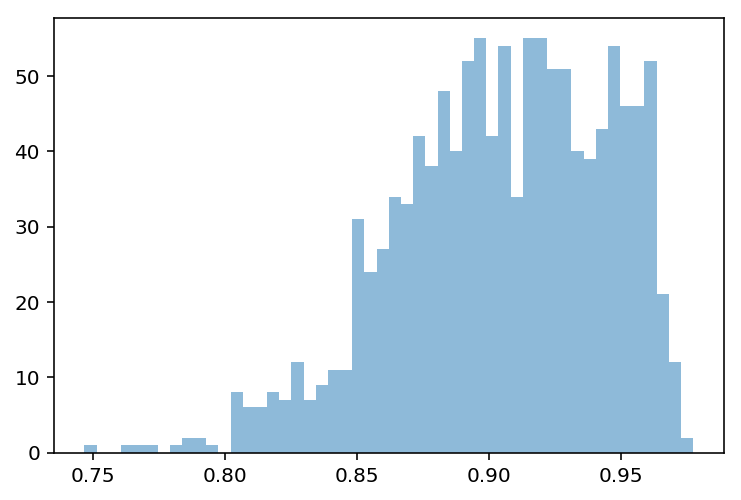

In [17]:
plt.hist(y_preds[:, 0], bins=50, alpha=0.5)
plt.show()

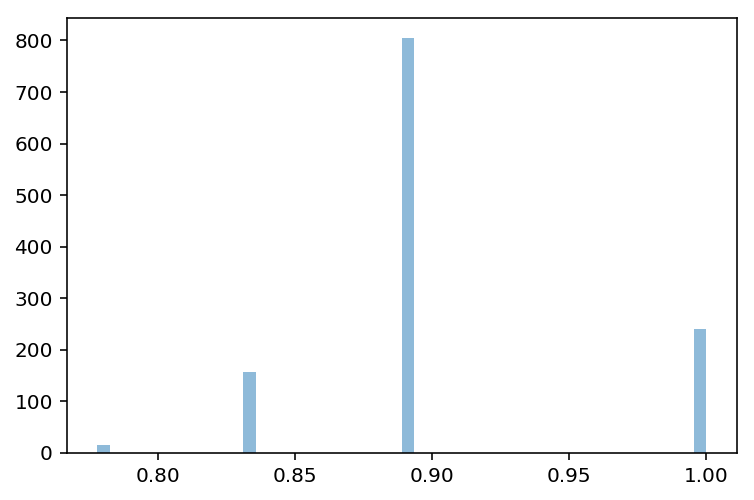

In [18]:
plt.hist(assigned_y_preds[:, 0], bins=50, alpha=0.5)
plt.show()

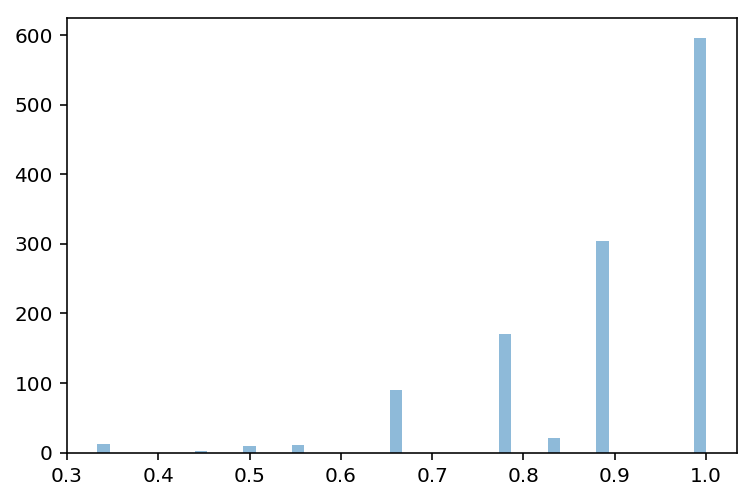

In [19]:
plt.hist(y_trues[:, 0], bins=50, alpha=0.5)
plt.show()

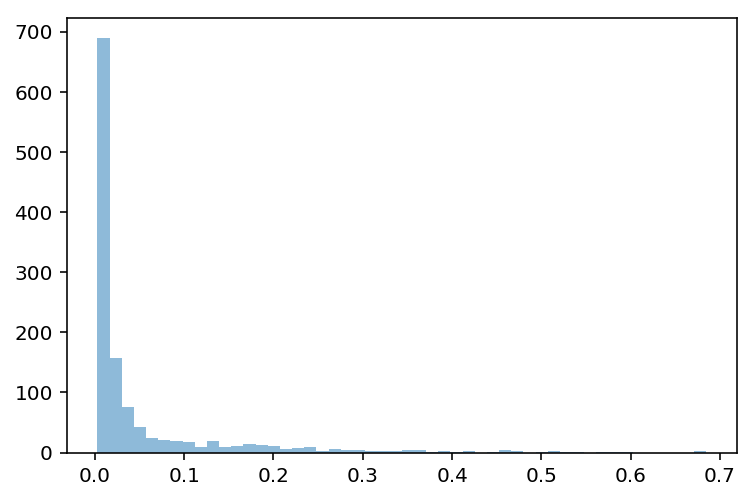

In [72]:
plt.hist(y_preds[:, 2], bins=50, alpha=0.5)
plt.show()

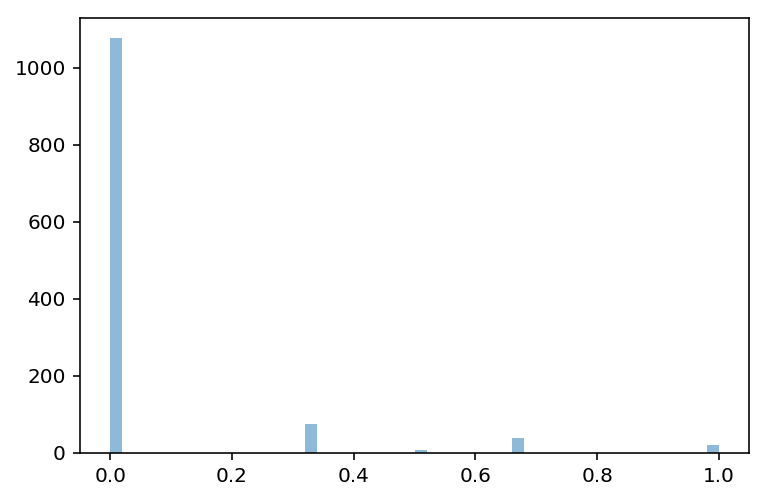

In [70]:
plt.hist(y_trues[:, 2], bins=50, alpha=0.5)
plt.show()

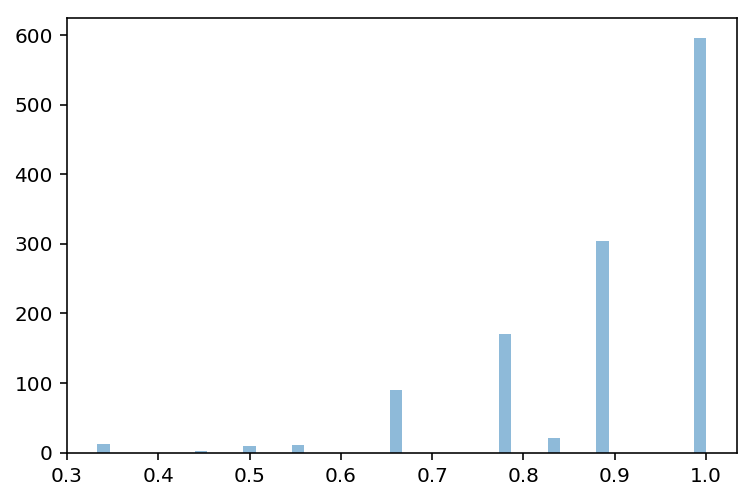

In [68]:
plt.hist(y_trues[:, 0], bins=50, alpha=0.5)
plt.show()

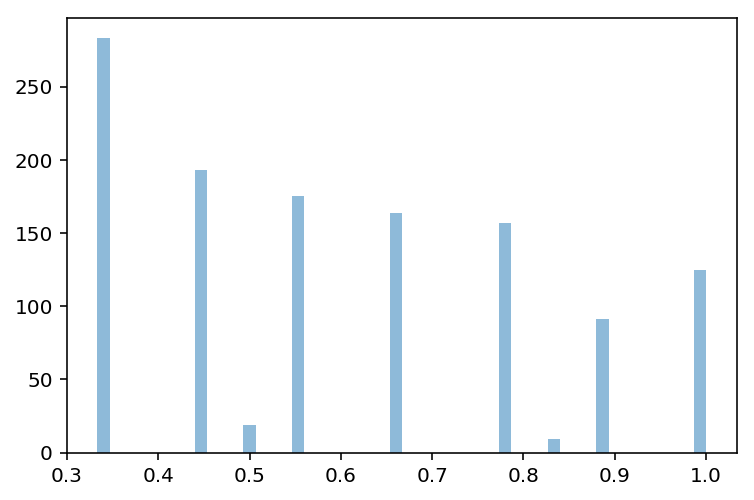

In [69]:
plt.hist(y_trues[:, 1], bins=50, alpha=0.5)
plt.show()

In [64]:
y_trues[:, 0]

array([1.        , 1.        , 0.88888889, ..., 1.        , 1.        ,
       0.55555556])

In [94]:
pd.Series(compute_spearmanr(y_trues, assigned_y_preds)).dropna().mean()

0.4020795355177934

In [117]:
compute_spearmanr(y_trues, assigned_y_preds)

[0.33694931413303936,
 0.5525639350710876,
 0.3514474183190364,
 0.2790888271349788,
 0.32845886497854104,
 0.4718309500798249,
 0.30166672081003904,
 0.4616868042196653,
 0.4717855816387441,
 -0.003415984857890416,
 0.40183148092510923,
 0.7008105302924496,
 0.4343182161053076,
 -0.0045624210801053135,
 0.5337619564287965,
 0.5680669608518802,
 0.7703271971978511,
 0.30327653885548134,
 0.5896460332270635,
 -0.0008230452674897118,
 0.438142569365688,
 0.20426918996372181,
 0.3569257568408338,
 0.042490688054867144,
 0.14127863610770514,
 0.24918357377616956,
 0.7471845567539979,
 0.16108587246863346,
 0.6114954390512181,
 0.046573846328690896]

In [118]:
compute_spearmanr(y_trues, y_preds)

[0.3856205266786172,
 0.5642944592519713,
 0.3648977582400921,
 0.2807956949964488,
 0.3407843836222576,
 0.41629700238625356,
 0.33256336947298026,
 0.4603482186215454,
 0.4895274877110685,
 0.08230136471024098,
 0.4315544827430897,
 0.6977130369880749,
 0.3447266306677803,
 0.1426499364340046,
 0.3635422315645105,
 0.49749729882651605,
 0.7675576318980243,
 0.3468981396755381,
 0.6060694289979107,
 0.02047277842728809,
 0.4533002553260622,
 0.20403645037378346,
 0.40568754344385966,
 0.06819472765688128,
 0.11774058977977347,
 0.2558148949045074,
 0.7479560394805845,
 0.2750461619264568,
 0.6186977771859813,
 0.17202034553643206]

In [97]:
np.unique(assigned_y_preds[:, 9])

array([0.])

In [98]:
y_preds[:, 9]

array([0.00991869, 0.00585603, 0.00300788, ..., 0.00155775, 0.00286855,
       0.00290035], dtype=float32)

In [100]:
np.unique(y_trues[:, 9])

array([0.        , 0.33333333, 0.5       , 0.66666667])

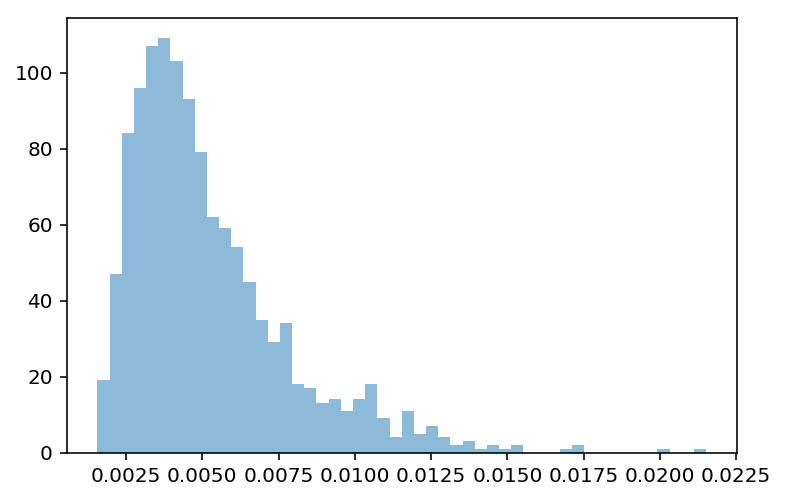

In [101]:
plt.hist(y_preds[:, 9], bins=50, alpha=0.5)
plt.show()

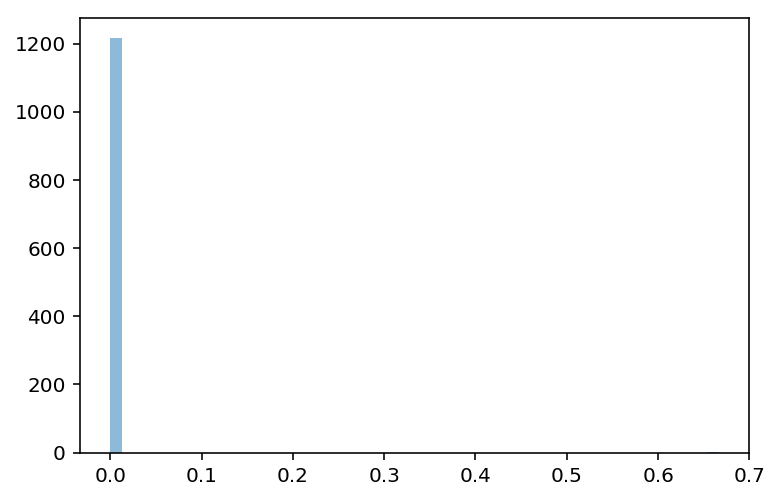

In [119]:
plt.hist(assigned_y_preds[:, 9], bins=50, alpha=0.5)
plt.show()

In [113]:
np.unique(assigned_y_preds[:, 9])

array([0.        , 0.66666667])

In [109]:
np.unique(y_trues[:, 9])

array([0.        , 0.33333333, 0.5       , 0.66666667])

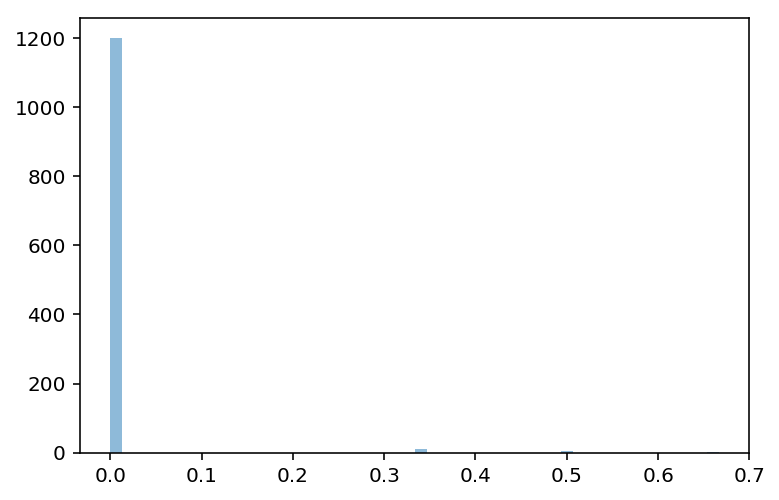

In [102]:
plt.hist(y_trues[:, 9], bins=50, alpha=0.5)
plt.show()

## ヒストグラムベースやる

In [49]:
for i, row in pd.Series(y_trues[:, 0]).value_counts(normalize=True).sort_index().cumsum().reset_index().iterrows():
    value, ratio = row.values
    print(value, ratio)

0.3333333333333333 0.009868421052631578
0.4444444444444444 0.012335526315789474
0.5 0.019736842105263157
0.5555555555555556 0.028782894736842105
0.6666666666666666 0.10279605263157894
0.7777777777777778 0.24342105263157893
0.8333333333333334 0.2606907894736842
0.8888888888888888 0.5106907894736842
1.0 1.0


In [118]:
def assign_histogram_band(all_y_trues, all_y_preds):
    all_res = []
    for col_idx in range(30):
        y_trues = all_y_trues[:, col_idx].copy()
        y_preds = all_y_preds[:, col_idx].copy()

        y_preds_df = pd.DataFrame(y_preds, columns=['y_pred'])
        y_preds_df['normed_rank'] = (y_preds_df.y_pred.rank() / y_preds_df.shape[0]).values
        _bef_ratio = -1
        for i, row in pd.Series(y_trues).value_counts(normalize=True).sort_index().cumsum().reset_index().iterrows():
            value, ratio = row.values
            print(((y_preds_df.normed_rank > _bef_ratio).values & (y_preds_df.normed_rank <= ratio).values).sum())
            y_preds_df.loc[(y_preds_df.normed_rank > _bef_ratio).values & (y_preds_df.normed_rank <= ratio).values, 'y_pred'] = value
            _bef_ratio = ratio
        all_res.append(y_preds_df.y_pred.values)
    return np.asarray(all_res).T

In [119]:
res = assign_histogram_band(y_trues, y_preds)
res.shape

12
3
9
11
90
170
21
305
595
283
193
19
175
164
157
9
91
125
1076
73
8
38
21
171
105
84
285
571
65
158
14
273
706
140
65
52
167
792
51
242
47
361
366
83
7
34
24
385
304
41
168
132
83
11
42
50
723
222
16
144
111
1199
10
6
1
399
287
35
290
205
689
206
19
136
166
1126
42
2
27
19
1186
17
3
7
3
1140
31
2
30
12
1035
94
6
45
36
447
133
33
197
406
796
249
22
111
38
506
275
19
196
220
1215
1
22
64
7
107
150
243
35
270
318
5
5
12
72
107
48
250
717
30
46
33
129
812
98
23
26
18
2
4
34
40
45
156
935
1
1
1
2
18
37
33
152
971
1
2
1
1
7
8
4
17
46
50
13
68
255
188
80
214
261
467
134
31
213
370
857
247
20
70
22
381
226
29
224
356
1
2
9
65
149
31
441
518


(1216, 30)

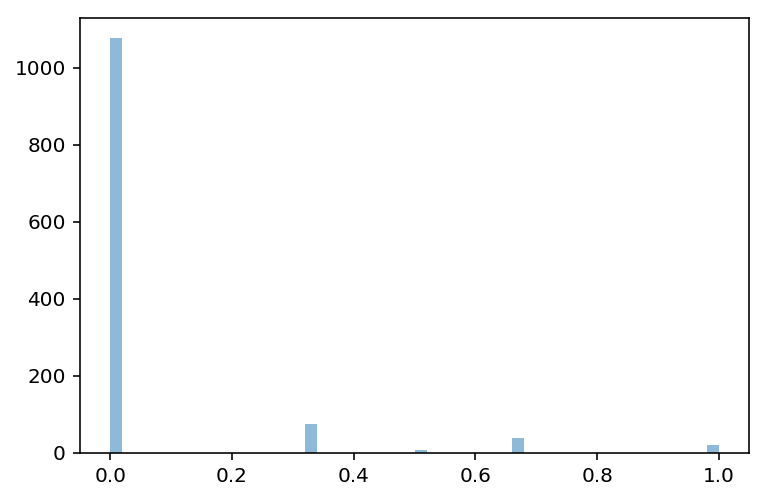

In [104]:
plt.hist(y_trues[:, 2], bins=50, alpha=0.5)
plt.show()

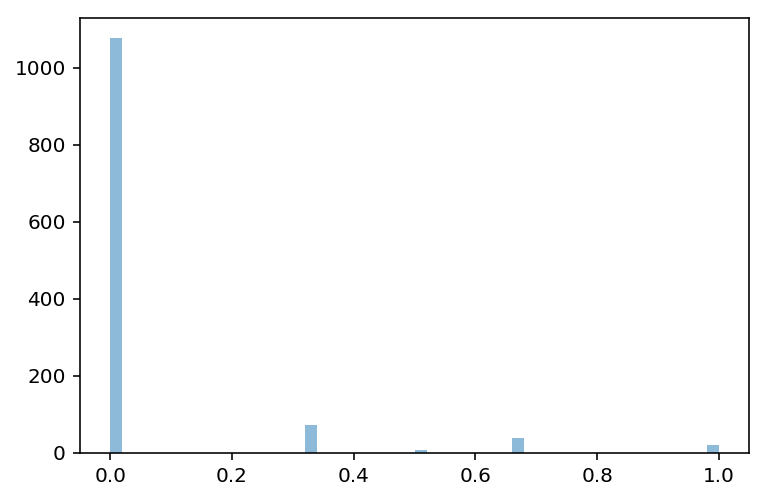

In [105]:
plt.hist(res[:, 2], bins=50, alpha=0.5)
plt.show()

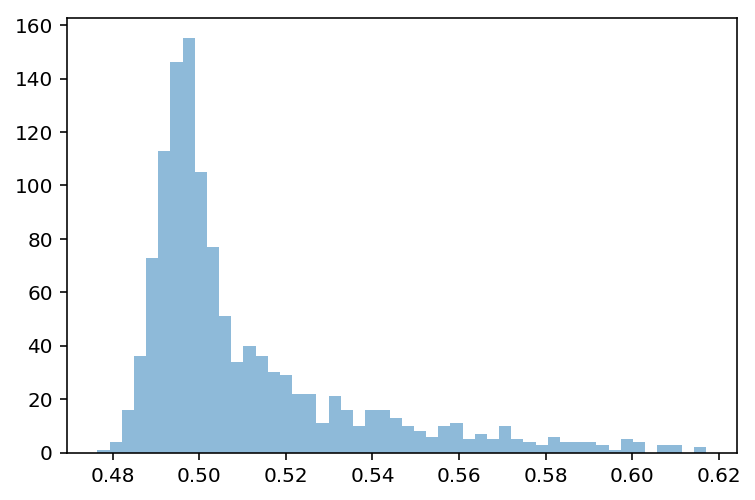

In [106]:
plt.hist(y_preds[:, 2], bins=50, alpha=0.5)
plt.show()

In [107]:
compute_spearmanr(y_trues, res)

[0.33229973211974567,
 0.5813069758073993,
 0.38346781825695514,
 0.25900115792697764,
 0.3423576956053028,
 0.457355438797686,
 0.3360614416191135,
 0.48582129422637343,
 0.5167068901448133,
 -0.014177777347443979,
 0.39447974962945076,
 0.7330118680566508,
 0.5267377233629459,
 0.07623794958305534,
 0.6565733373935888,
 0.5979694846545532,
 0.7680301112339899,
 0.27911396173337305,
 0.5994798166990314,
 -0.0008230452674897118,
 0.4533616382723037,
 0.12858762727147793,
 0.3727093942502885,
 0.01954998221101455,
 0.0546843213856112,
 0.25226098306415906,
 0.7454348444326047,
 0.22270752734441374,
 0.5946536993786803,
 0.15444370999021162]

In [127]:
np.mean(compute_spearmanr(y_trues, res))

0.36908493434593226

In [128]:
np.mean(compute_spearmanr(y_trues, y_preds))

0.3751535549176177

In [132]:
np.mean(compute_spearmanr(y_trues, assigned_y_preds))

0.3615782002591646

In [123]:
compute_spearmanr(y_trues, assigned_y_preds)

[0.33694931413303936,
 0.5525639350710876,
 0.3514474183190364,
 0.2790888271349788,
 0.32845886497854104,
 0.4718309500798249,
 0.30166672081003904,
 0.4616868042196653,
 0.4717855816387441,
 -0.003415984857890416,
 0.40183148092510923,
 0.7008105302924496,
 0.4343182161053076,
 -0.0045624210801053135,
 0.5337619564287965,
 0.5680669608518802,
 0.7703271971978511,
 0.30327653885548134,
 0.5896460332270635,
 -0.0008230452674897118,
 0.438142569365688,
 0.20426918996372181,
 0.3569257568408338,
 0.042490688054867144,
 0.14127863610770514,
 0.24918357377616956,
 0.7471845567539979,
 0.16108587246863346,
 0.6114954390512181,
 0.046573846328690896]

## label 見てみる

In [136]:
df = pd.read_csv('../mnt/inputs/origin/train.csv')

In [137]:
df.head()

qa_id                                     question_title  \
0      0  What am I losing when using extension tubes in...   
1      1  What is the distinction between a city and a s...   
2      2  Maximum protusion length for through-hole comp...   
3      3              Can an affidavit be used in Beit Din?   
4      5       How do you make a binary image in Photoshop?   

                                       question_body question_user_name  \
0  After playing around with macro photography on...               ysap   
1  I am trying to understand what kinds of places...      russellpierce   
2  I'm working on a PCB that has through-hole com...          Joe Baker   
3  An affidavit, from what i understand, is basic...         Scimonster   
4  I am trying to make a binary image. I want mor...            leigero   

                                  question_user_page  \
0         https://photo.stackexchange.com/users/1024   
1           https://rpg.stackexchange.com/users/8774   
2  https://electronics.stackexchange.com/users/10157   
3       https://judaism.stackexchange.com/users/5151   
4  https://graphicdesign.stackexchange.com/users/...   

                                              answer answer_user_name  \
0  I just got extension tubes, so here's the skin...           rfusca   
1  It might be helpful to look into the definitio...     Erik Schmidt   
2  Do you even need grooves?  We make several pro...      Dwayne Reid   
3  Sending an "affidavit" it is a dispute between...    Y     e     z   
4  Check out Image Trace in Adobe Illustrator. \n...             q2ra   

                                    answer_user_page  \
0         https://photo.stackexchange.com/users/1917   
1           https://rpg.stackexchange.com/users/1871   
2  https://electronics.stackexchange.com/users/64754   
3       https://judaism.stackexchange.com/users/4794   
4  https://graphicdesign.stackexchange.com/users/...   

                                                 url   category  \
0  http://photo.stackexchange.com/questions/9169/...  LIFE_ARTS   
1  http://rpg.stackexchange.com/questions/47820/w...    CULTURE   
2  http://electronics.stackexchange.com/questions...    SCIENCE   
3  http://judaism.stackexchange.com/questions/551...    CULTURE   
4  http://graphicdesign.stackexchange.com/questio...  LIFE_ARTS   

                              host  question_asker_intent_understanding  \
0          photo.stackexchange.com                             1.000000   
1            rpg.stackexchange.com                             1.000000   
2    electronics.stackexchange.com                             0.888889   
3        judaism.stackexchange.com                             0.888889   
4  graphicdesign.stackexchange.com                             1.000000   

   question_body_critical  question_conversational  \
0                0.333333                 0.000000   
1                1.000000                 0.000000   
2                0.666667                 0.000000   
3                0.666667                 0.666667   
4                0.666667                 0.000000   

   question_expect_short_answer  question_fact_seeking  \
0                           0.0                    0.0   
1                           0.5                    1.0   
2                           1.0                    1.0   
3                           1.0                    1.0   
4                           1.0                    1.0   

   question_has_commonly_accepted_answer  question_interestingness_others  \
0                                    0.0                         1.000000   
1                                    1.0                         0.444444   
2                                    1.0                         0.666667   
3                                    1.0                         0.444444   
4                                    1.0                         0.666667   

   question_interestingness_self  question_multi_intent  \
0         

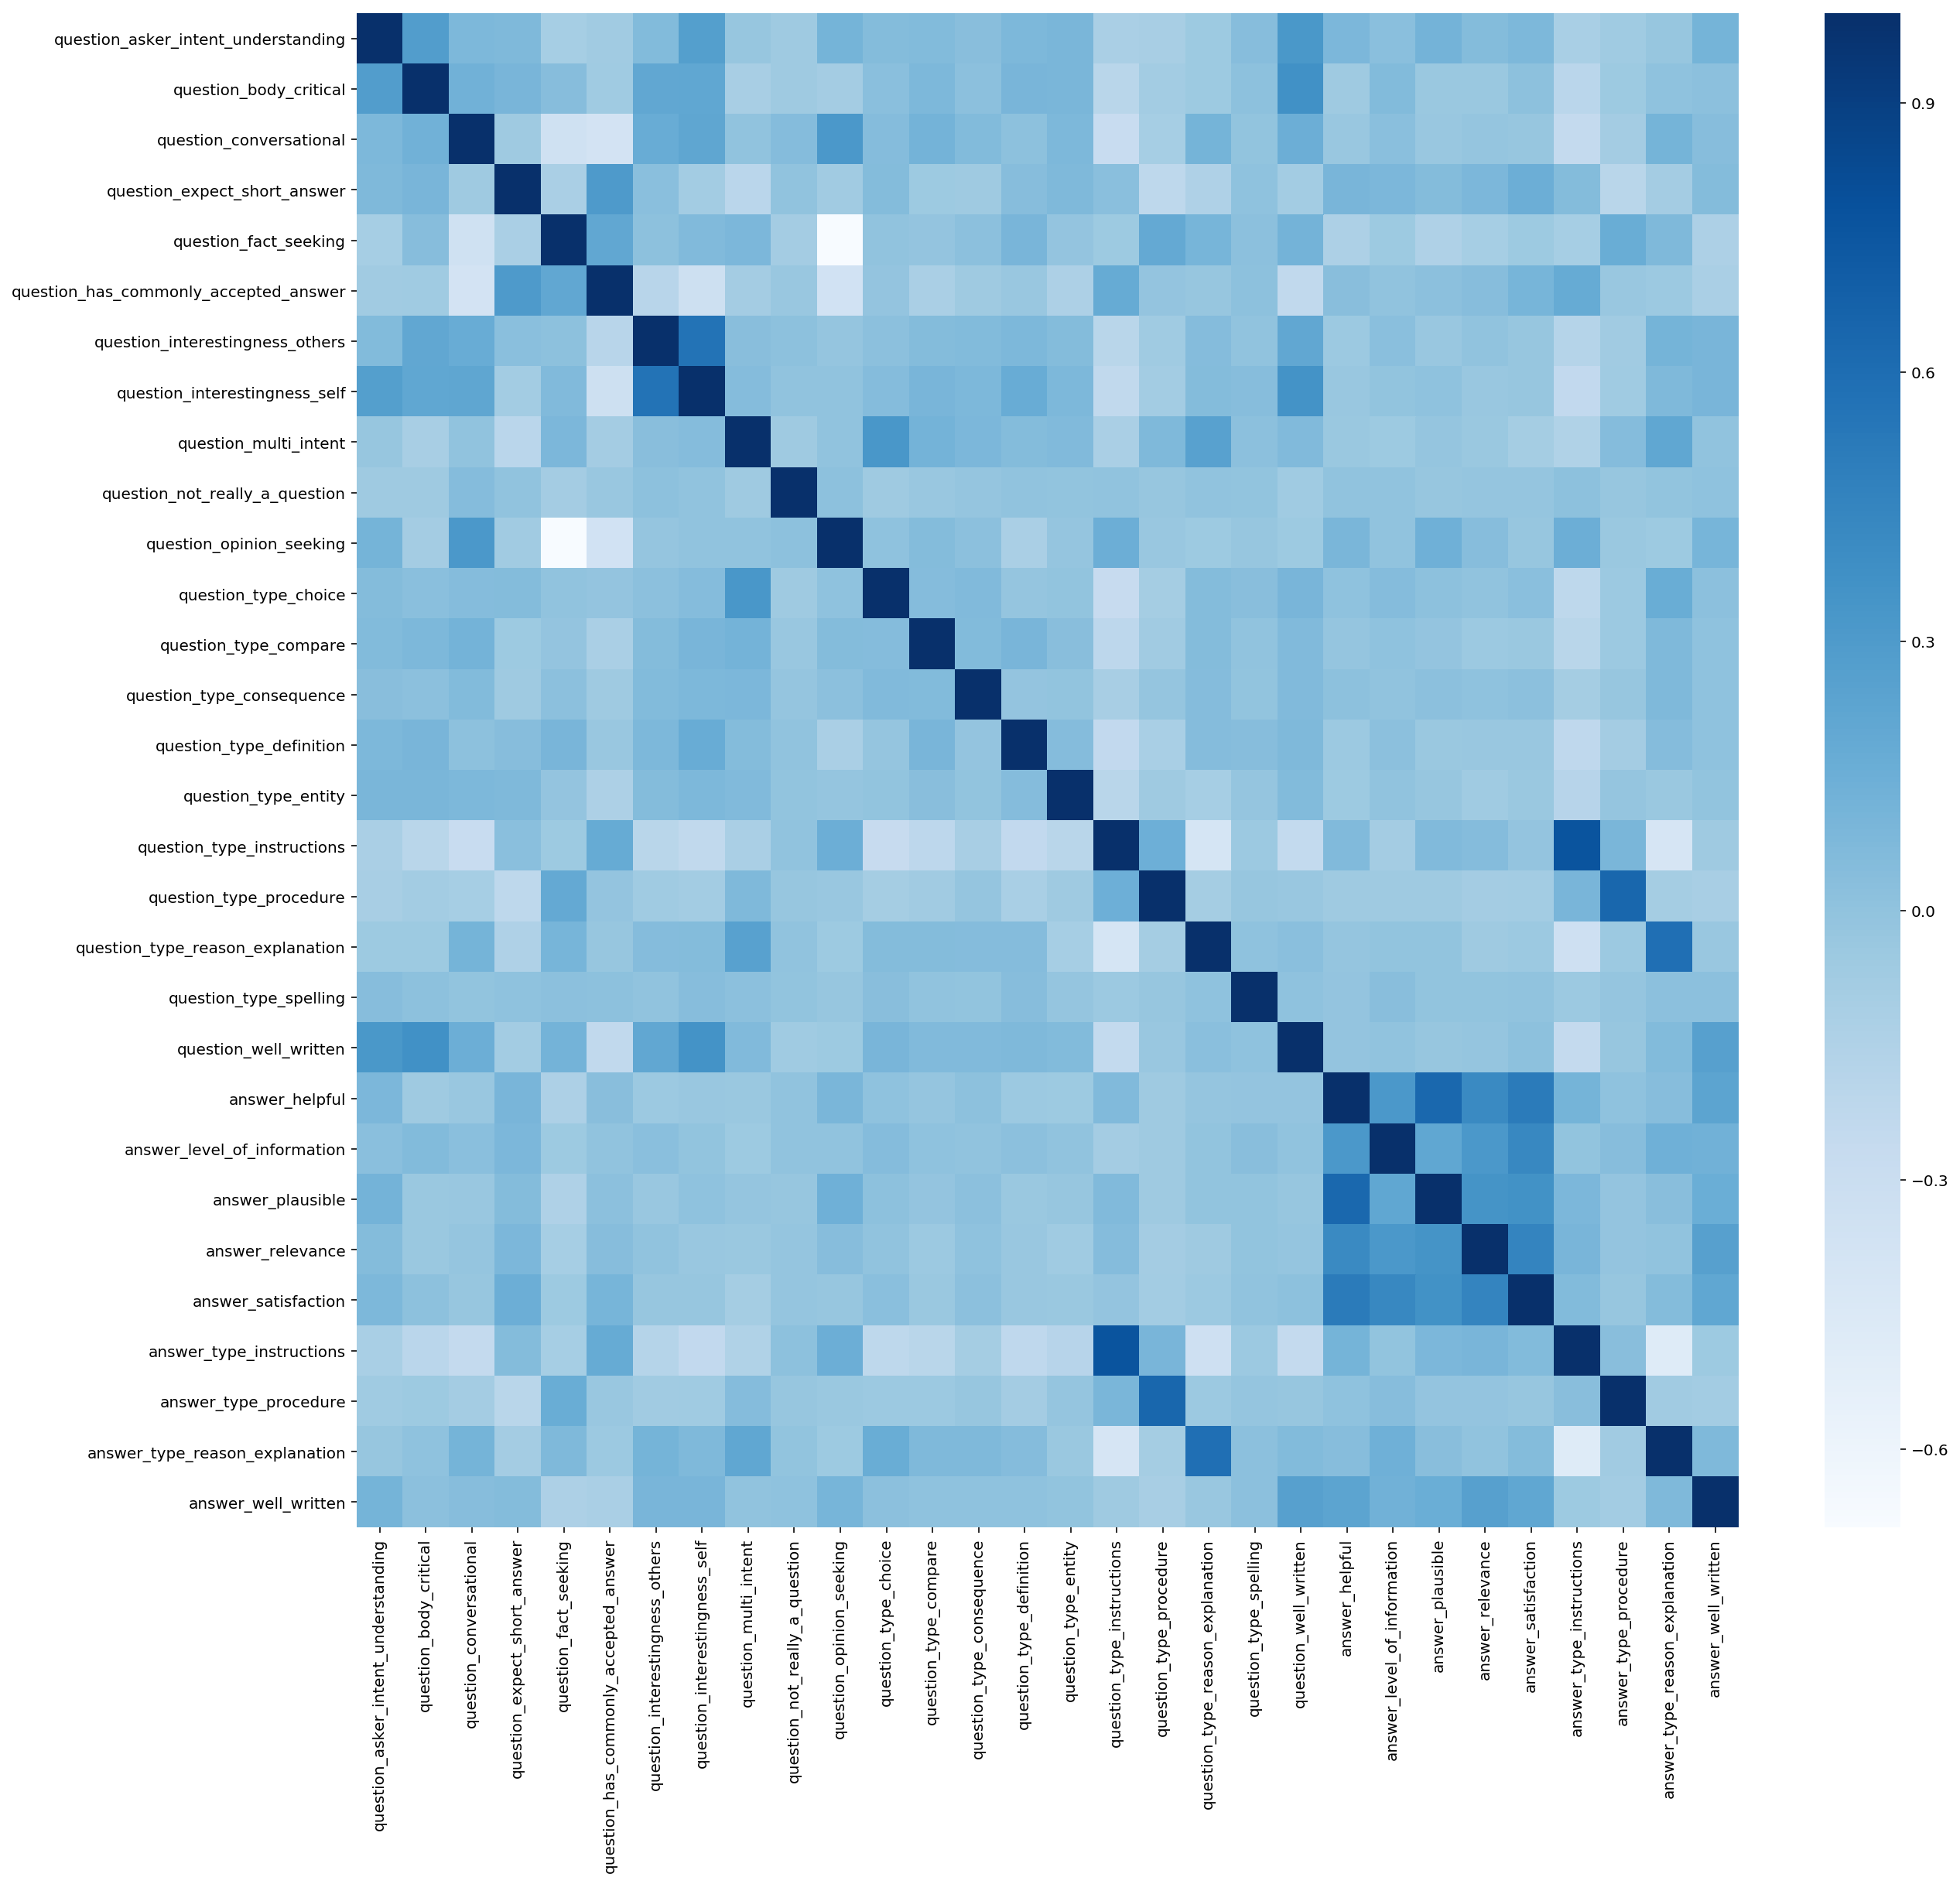

In [142]:
plt.figure(figsize=(20, 18))
sns.heatmap(df.iloc[:, 11:].corr(method='spearman'), cmap='Blues')

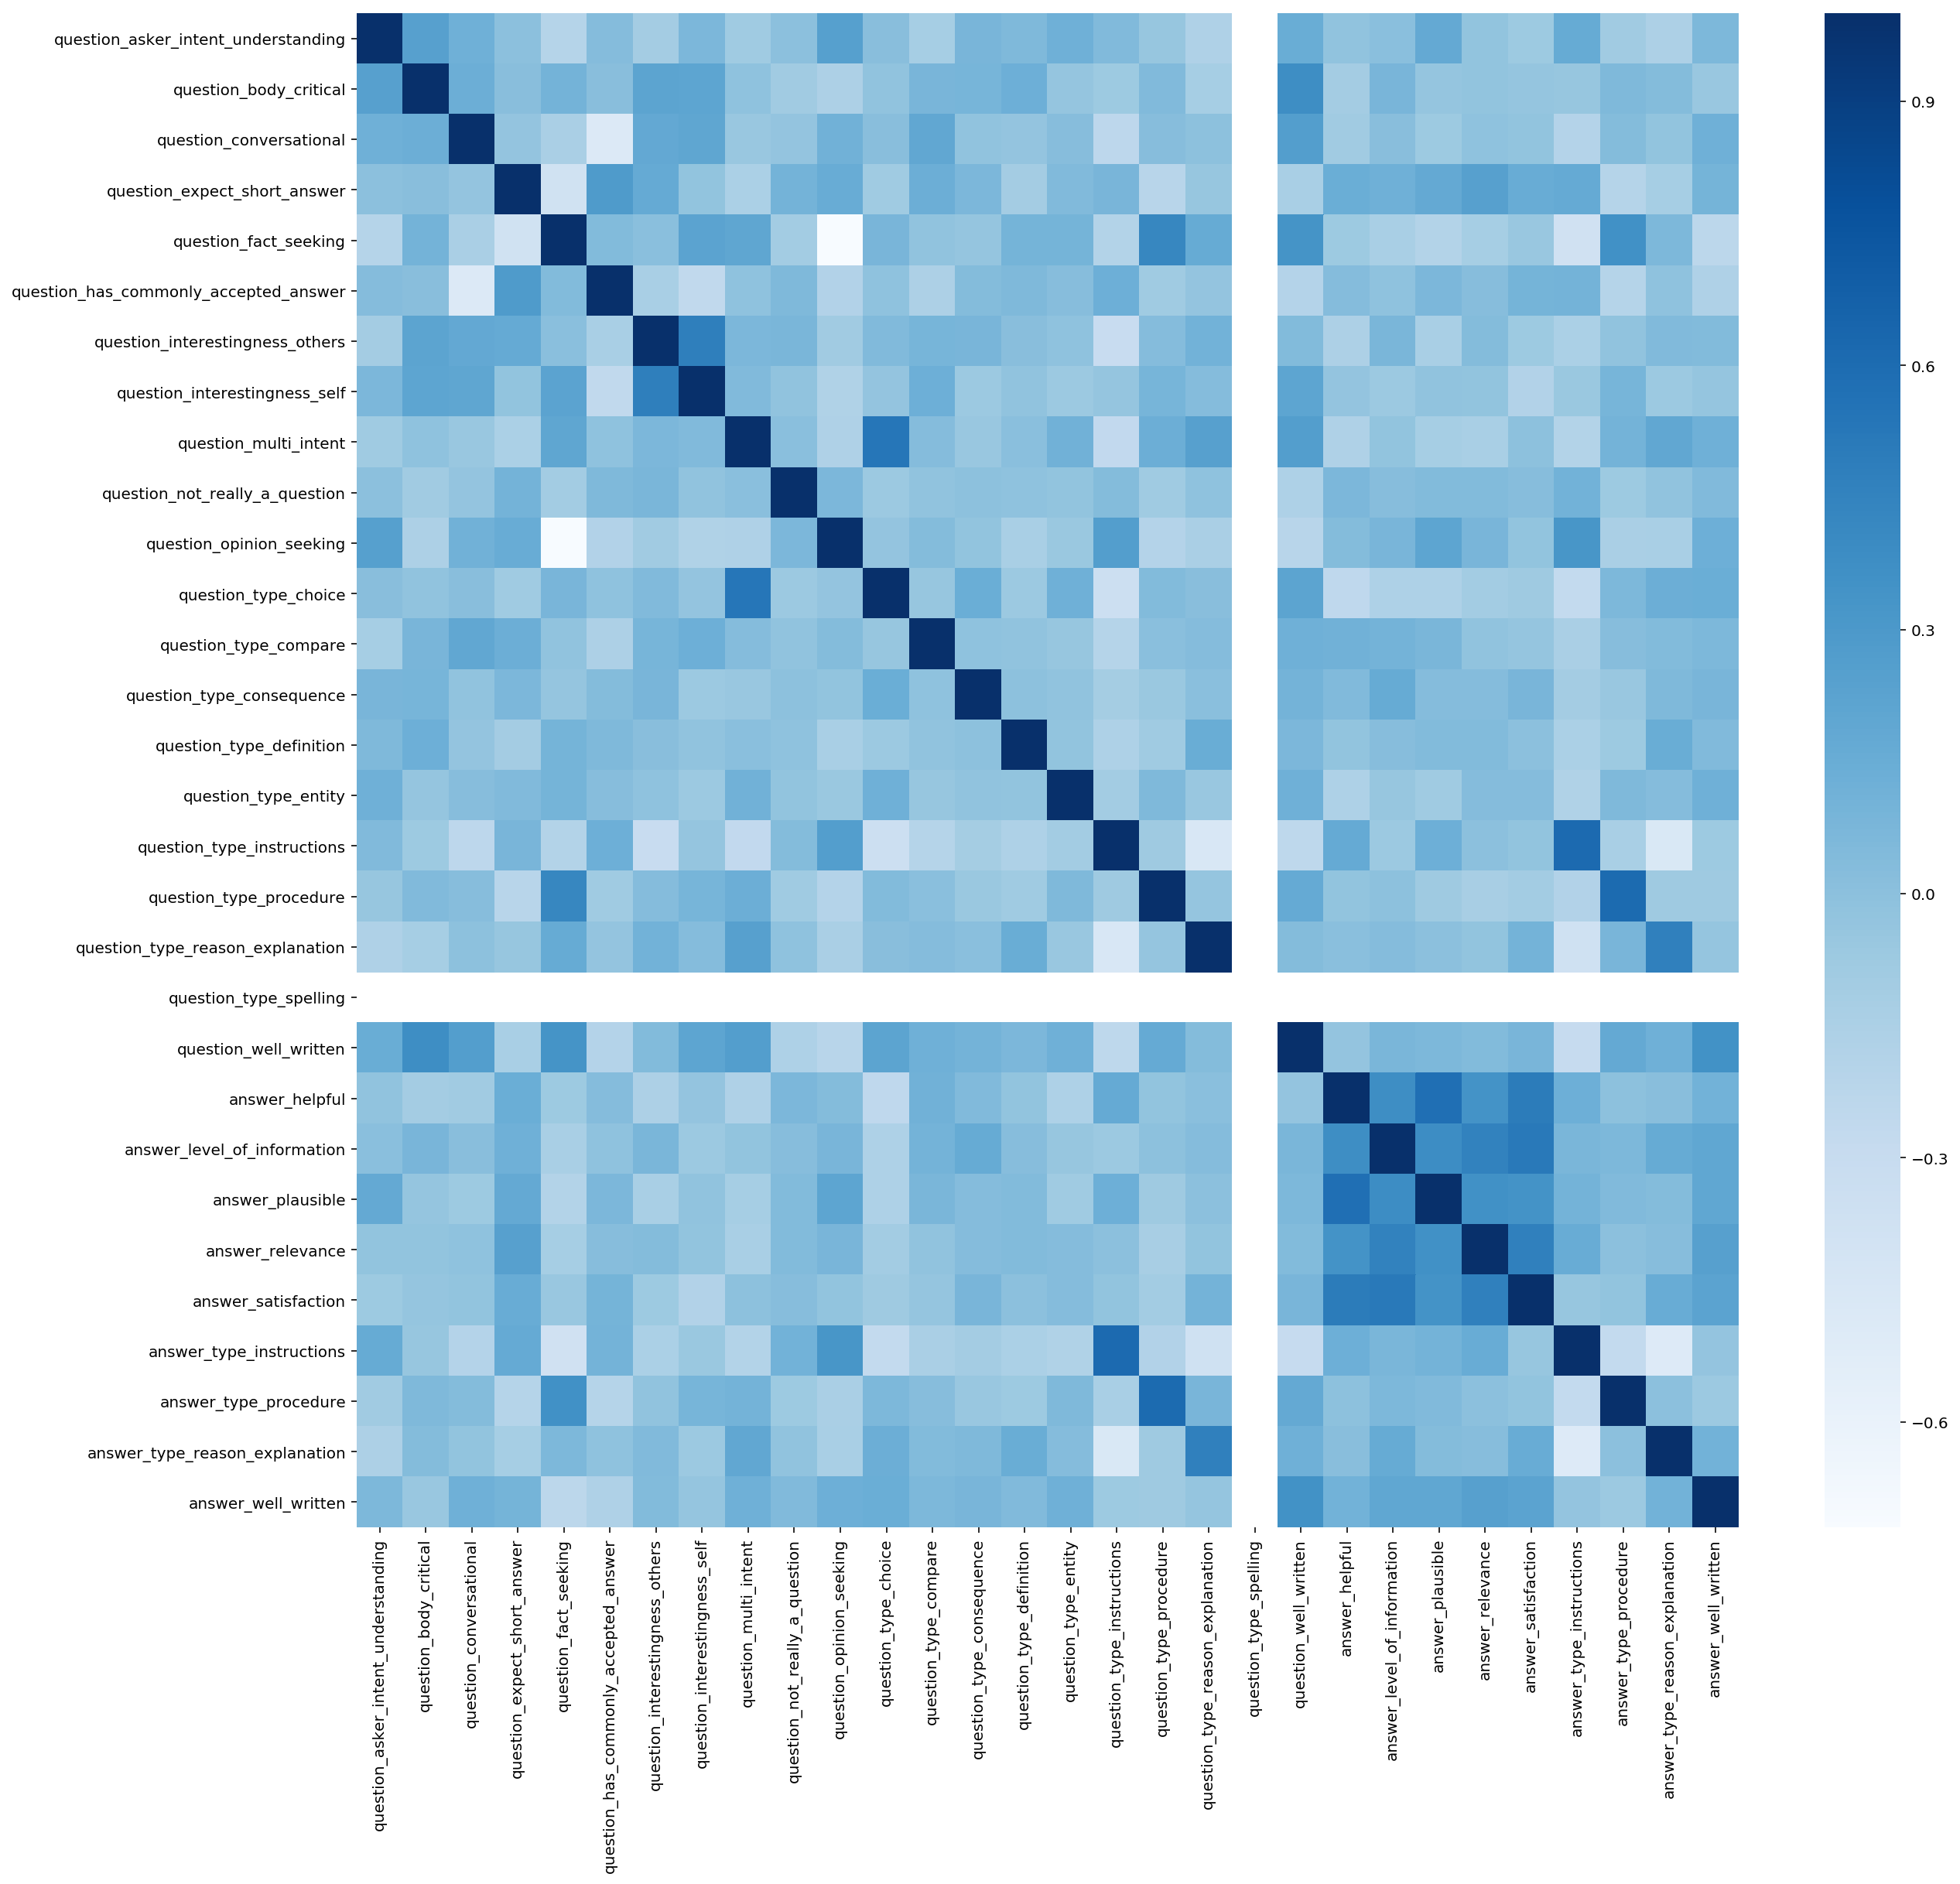

In [144]:
plt.figure(figsize=(20, 18))
sns.heatmap(df.query('question_user_name == answer_user_name').iloc[:, 11:].corr(method='spearman'), cmap='Blues')

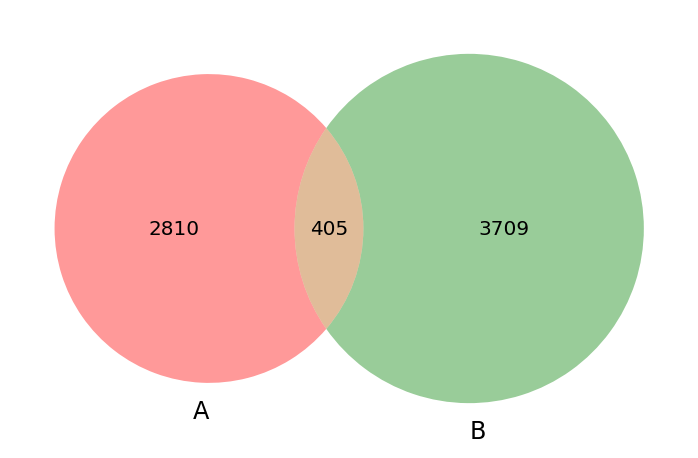

In [148]:
venn2([set(df.question_user_name), set(df.answer_user_name)])

In [152]:
df.iloc[:, 11:].columns.tolist()

['question_asker_intent_understanding',
 'question_body_critical',
 'question_conversational',
 'question_expect_short_answer',
 'question_fact_seeking',
 'question_has_commonly_accepted_answer',
 'question_interestingness_others',
 'question_interestingness_self',
 'question_multi_intent',
 'question_not_really_a_question',
 'question_opinion_seeking',
 'question_type_choice',
 'question_type_compare',
 'question_type_consequence',
 'question_type_definition',
 'question_type_entity',
 'question_type_instructions',
 'question_type_procedure',
 'question_type_reason_explanation',
 'question_type_spelling',
 'question_well_written',
 'answer_helpful',
 'answer_level_of_information',
 'answer_plausible',
 'answer_relevance',
 'answer_satisfaction',
 'answer_type_instructions',
 'answer_type_procedure',
 'answer_type_reason_explanation',
 'answer_well_written']

In [164]:
_dict = df['question_asker_intent_understanding'].drop_duplicates().sort_values().reset_index(drop=True).reset_index().set_index('question_asker_intent_understanding').to_dict()['index']
_dict

{0.3333333333333333: 0,
 0.4444444444444444: 1,
 0.5: 2,
 0.5555555555555556: 3,
 0.6666666666666666: 4,
 0.7777777777777778: 5,
 0.8333333333333334: 6,
 0.8888888888888888: 7,
 1.0: 8}

In [165]:
df['question_asker_intent_understanding'].map(_dict)

0       8
1       8
2       7
3       7
4       8
       ..
6074    8
6075    8
6076    7
6077    8
6078    8
Name: question_asker_intent_understanding, Length: 6079, dtype: int64

In [169]:
torch.zeros(y_trues.shape).shape

torch.Size([1216, 30])

In [170]:
a = torch.nn.Softmax()

In [182]:
a(torch.tensor(y_preds)).argmax(dim=1)#.sum(dim=1).shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([ 0, 24, 24,  ..., 24,  0, 24])

In [186]:
torch.tensor(y_preds).size()

torch.Size([1216, 30])

## optimized rounder

In [35]:
import scipy as sp
from functools import partial
from scipy.stats import spearmanr

class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """

    def __init__(self):
        self.coef_ = 0

    def _spearmanr_loss(self, coef, X, y, labels):
        """
        Get loss according to
        using current coefficients
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) +
                     [np.inf], labels=labels)

        # return -np.mean(spearmanr(y, X_p).correlation)
        return -spearmanr(y, X_p).correlation

    def fit(self, X, y, initial_coef, labels):
        """
        Optimize rounding thresholds
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._spearmanr_loss, X=X, y=y, labels=labels)
        self.coef_ = sp.optimize.minimize(
            loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef, labels):
        """
        Make predictions with specified thresholds
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) +
                      [np.inf], labels=labels)
                      # [np.inf], labels=[0, 1, 2, 3])

    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

In [36]:
optR = OptimizedRounder()

In [37]:
optR.fit(y_preds[:, 0], y_trues[:, 0], initial_coef=np.sort(np.unique(y_trues[:, 0]))[:-1], labels=np.sort(np.unique(y_trues[:, 0])))

In [46]:
res = optR.predict(y_preds[:, 0], optR.coefficients(), np.sort(np.unique(y_trues[:, 0])))

In [44]:
optR.coefficients()

array([0.33575762, 0.447628  , 0.50351284, 0.55936334, 0.66328046,
       0.77863161, 0.82942505, 0.90780123])

In [70]:
reses = []

for i in range(30):
    optR = OptimizedRounder()
    labels = np.sort(np.unique(y_trues[:, i]))
    initial_coef = (labels[:-1] + labels[1:]) / 2
    optR.fit(y_preds[:, i], y_trues[:, i], initial_coef=initial_coef, labels=labels)
    res = optR.predict(y_preds[:, i], optR.coefficients(), np.sort(np.unique(y_trues[:, i])))
    reses.append(res)

In [52]:
len(reses)

30

In [67]:
np.asarray(reses).shape

(30, 1216)

In [69]:
compute_spearmanr(y_trues, y_preds)

[0.3856205266786172,
 0.5642944592519713,
 0.3648977582400921,
 0.2807956949964488,
 0.3407843836222576,
 0.41629700238625356,
 0.33256336947298026,
 0.4603482186215454,
 0.4895274877110685,
 0.08230136471024098,
 0.4315544827430897,
 0.6977130369880749,
 0.3447266306677803,
 0.1426499364340046,
 0.3635422315645105,
 0.49749729882651605,
 0.7675576318980243,
 0.3468981396755381,
 0.6060694289979107,
 0.02047277842728809,
 0.4533002553260622,
 0.20403645037378346,
 0.40568754344385966,
 0.06819472765688128,
 0.11774058977977347,
 0.2558148949045074,
 0.7479560394805845,
 0.2750461619264568,
 0.6186977771859813,
 0.17202034553643206]

In [68]:
compute_spearmanr(y_trues, np.asarray(reses).T)

[0.36039056783630713,
 0.5691068835095334,
 0.286408193844324,
 0.23618403240773508,
 0.340841069465261,
 0.47790180493912443,
 0.35969736906577754,
 0.48027676507764155,
 0.47521903006113336,
 nan,
 0.41832490240438286,
 0.7159120032848557,
 0.5421693546501547,
 nan,
 0.46288232910625526,
 0.5044105752412117,
 0.7697603772870992,
 0.14099480278730167,
 0.5829622842480943,
 nan,
 0.4603925618800718,
 0.23046375559589802,
 0.4080197460324716,
 0.0848538848918014,
 0.13935089305670806,
 0.2671918074459798,
 0.7336897357875375,
 0.05704059089873712,
 0.575552811388807,
 0.15898795676895516]

In [73]:
pd.Series(compute_spearmanr(y_trues, np.asarray(reses).T)).fillna(0).mean()

0.3858599601323884

In [75]:
np.mean(compute_spearmanr(y_trues, y_preds))

0.3751535549176177